In [1]:
import pywt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
#cifar10 dataset
import torchvision
import torchvision.transforms as transforms
import numpy as np

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

# normalization
X_train = trainset.data.astype(np.float32) / 255.0  # shape (50000, 32, 32, 3)
y_train = np.array(trainset.targets) # 라벨
X_test = testset.data.astype(np.float32) / 255.0
y_test = np.array(testset.targets)

## DWT 모든 성분/ low-pass, 저주파만 사용

In [3]:
# calculate DWT coeffs
def extract_dwt_features(img):
    all_coeffs = []
    approx_coeffs = []
    for c in range(3):
        cA, (cH, cV, cD) = pywt.dwt2(img[:, :, c], "haar")
        
        # 근사 계수(LL)
        approx_coeffs.append(cA.flatten())
        
        # 모든 계수 (LL, LH, HL, HH)
        all_coeffs.extend([cA.flatten(), cH.flatten(), cV.flatten(), cD.flatten()])
        
    return np.concatenate(approx_coeffs), np.concatenate(all_coeffs)

In [4]:
results_train = [extract_dwt_features(img) for img in X_train] 
X_train_dwt_approx, X_train_dwt_all = zip(*results_train) #separate LL only/ all coeffs

results_test = [extract_dwt_features(img) for img in X_test]
X_test_dwt_approx, X_test_dwt_all = zip(*results_test)

# 리스트를 numpy 배열로 변환
X_train_dwt_approx = np.array(X_train_dwt_approx)
X_train_dwt_all = np.array(X_train_dwt_all)
X_test_dwt_approx = np.array(X_test_dwt_approx)
X_test_dwt_all = np.array(X_test_dwt_all)

In [5]:
from sklearn.pipeline import Pipeline
# candidate k 1 - 20
k_values = list(range(1, 21))

# set pca -> knn training template
pca_knn_pipeline = Pipeline([
    ('pca', PCA(n_components=20)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

In [6]:
pca_knn_pipeline.fit(X_train_dwt_all, y_train)
y_pred_all = pca_knn_pipeline.predict(X_test_dwt_all)
acc_pipeline_all = accuracy_score(y_test, y_pred_all)

# without validation data
print(f"PCA -> kNN Accuracy: {acc_pipeline_all*100:.2f}%")


PCA -> kNN Accuracy: 39.30%


In [7]:
# Train -> Train/Validation split
from sklearn.model_selection import train_test_split


# Also create a stratified train/validation split for the 'approx' (low-pass) features
X_train_approx_train, X_val_approx, y_train_approx_train, y_val_approx = train_test_split(
    X_train_dwt_approx, y_train, test_size=0.2, random_state=42, stratify=y_train
)


Best k (approx, validation): 11


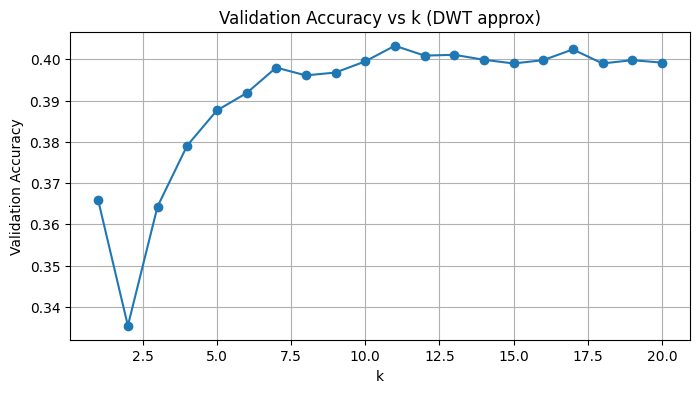

In [8]:
import matplotlib.pyplot as plt

val_scores_approx = []


for k in k_values:
    pca_knn_pipeline.set_params(knn__n_neighbors=k) #set k value
    pca_knn_pipeline.fit(X_train_approx_train, y_train_approx_train)
    # evaluate on validation split
    val_pred = pca_knn_pipeline.predict(X_val_approx)
    val_acc = accuracy_score(y_val_approx, val_pred)
    val_scores_approx.append(val_acc)

best_k_approx = k_values[int(np.argmax(val_scores_approx))]
print(f"Best k (approx, validation): {best_k_approx}")

plt.figure(figsize=(8,4))
plt.plot(k_values, val_scores_approx, '-o')
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs k (DWT approx)')
plt.grid(True)
plt.show()

In [9]:

pca_knn_pipeline.set_params(knn__n_neighbors=int(best_k_approx))

pca_knn_pipeline.fit(X_train_dwt_approx, y_train)
y_test_pred = pca_knn_pipeline.predict(X_test_dwt_approx)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy, best k={best_k_approx}: {test_acc*100:.2f}%")


Test accuracy, best k=11: 41.01%


In [10]:
from sklearn.model_selection import GridSearchCV
#automatic n-fold cross validation

grid_params = {
    'knn__n_neighbors' : k_values
}
scoring_metrics = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]

#cv = 5 to do 5 fold cross validation
grid_search = GridSearchCV(pca_knn_pipeline, grid_params, cv = 5, scoring=scoring_metrics, refit='accuracy')
grid_search.fit(X_train_dwt_all, y_train)



,estimator,Pipeline(step...ighbors=11))])
,param_grid,"{'knn__n_neighbors': [1, 2, ...]}"
,scoring,"['accuracy', 'precision_macro', ...]"
,n_jobs,None
,refit,'accuracy'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_components,20


In [12]:
# get best k params & estimator
best = grid_search.best_estimator_
y_test_pred_grid = best.predict(X_test_dwt_all)

acc_grid_test = accuracy_score(y_test, y_test_pred_grid)
best_k = best.get_params()['knn__n_neighbors']
print(f"best k:{best_k} Accuracy: {acc_grid_test*100:.2f}%")


best k:19 Accuracy: 41.90%


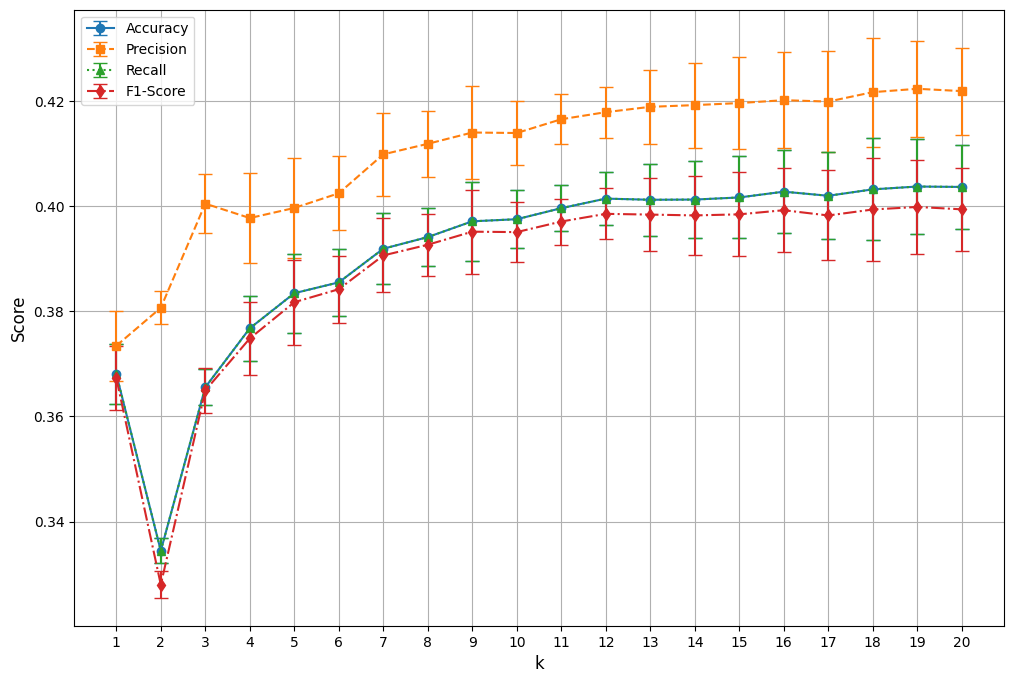

In [ ]:
from matplotlib import pyplot as plt

results= grid_search.cv_results_
k_values = results['param_knn__n_neighbors'].data.astype(int)

mean_accuracy = results["mean_test_accuracy"]
mean_precision = results["mean_test_precision_macro"]
mean_recall = results["mean_test_recall_macro"]
mean_f1 = results["mean_test_f1_macro"]

std_accuracy = results["std_test_accuracy"]
std_precision = results["std_test_precision_macro"]
std_recall = results["std_test_recall_macro"]
std_f1 = results["std_test_f1_macro"]

plt.figure(figsize=(12, 8))

plt.errorbar(
    k_values, mean_accuracy, yerr=std_accuracy, marker="o", capsize=5, label="Accuracy"
)
plt.errorbar(
    k_values,
    mean_precision,
    yerr=std_precision,
    marker="s",
    capsize=5,
    linestyle="--",
    label="Precision",
)
plt.errorbar(
    k_values,
    mean_recall,
    yerr=std_recall,
    marker="^",
    capsize=5,
    linestyle=":",
    label="Recall",
)
plt.errorbar(
    k_values,
    mean_f1,
    yerr=std_f1,
    marker="d",
    capsize=5,
    linestyle="-.",
    label="F1-Score",
)
plt.title('validation set results by k')
plt.xlabel("k", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()